In [1]:
from warnings import simplefilter
simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
url = 'https://raw.githubusercontent.com/VisheshManav/FinalYearProject/main/Data/DailyDelhiClimateTrain.csv'
df = pd.read_csv(url, index_col='date', parse_dates=True)

In [4]:
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


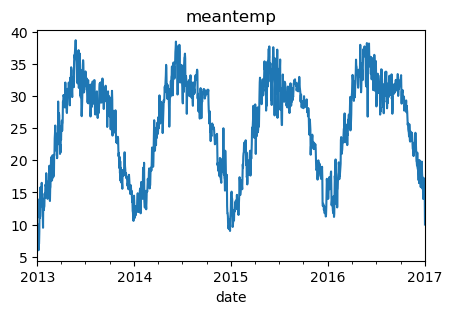

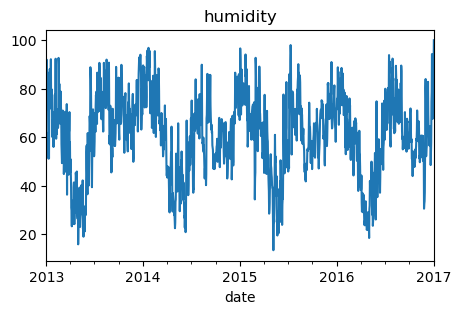

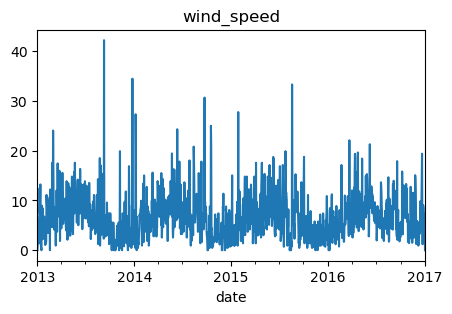

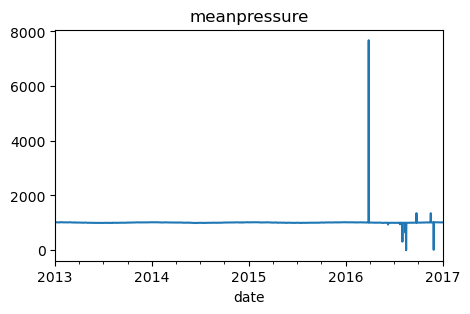

In [5]:
for column in df:
    plt.figure(figsize=(5, 3)) # Creates a new figure
    df[column].plot(kind='line') # Plots the column
    plt.title(column) # Sets the title of the plot as the column name
    plt.show() # Displays the plot

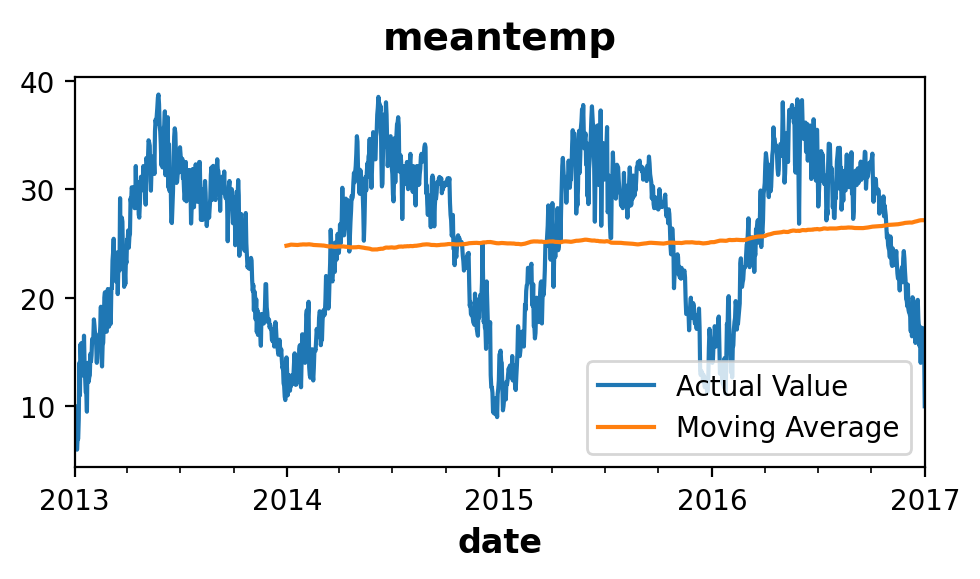

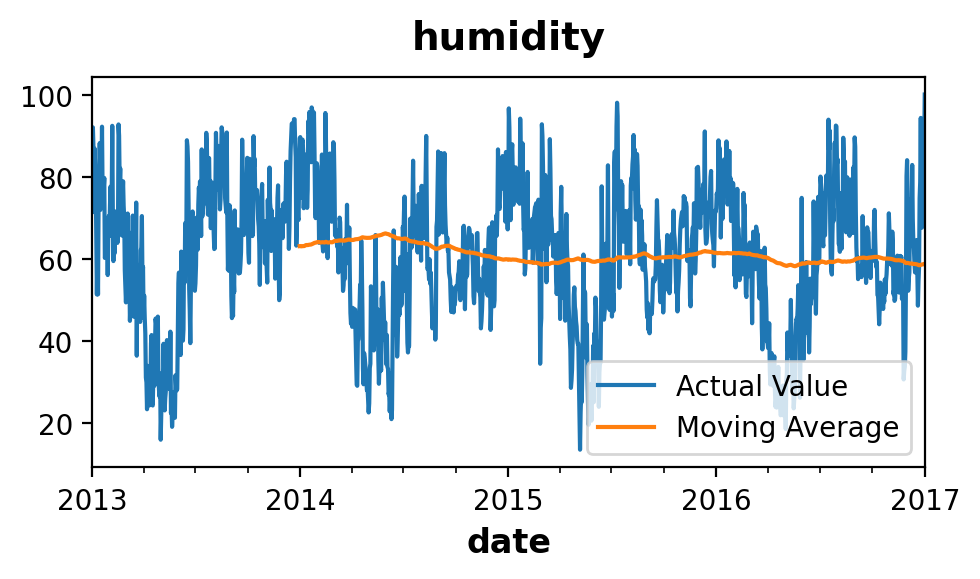

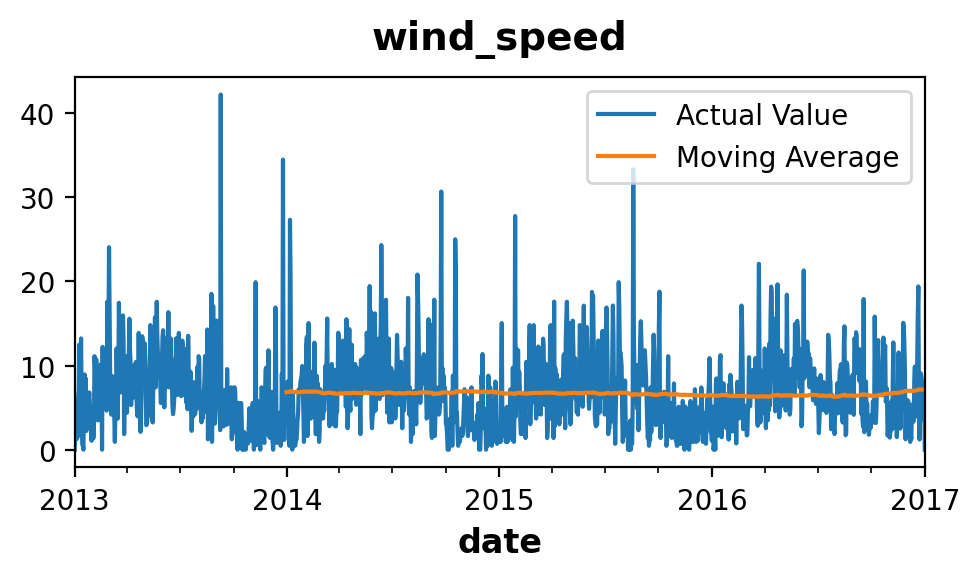

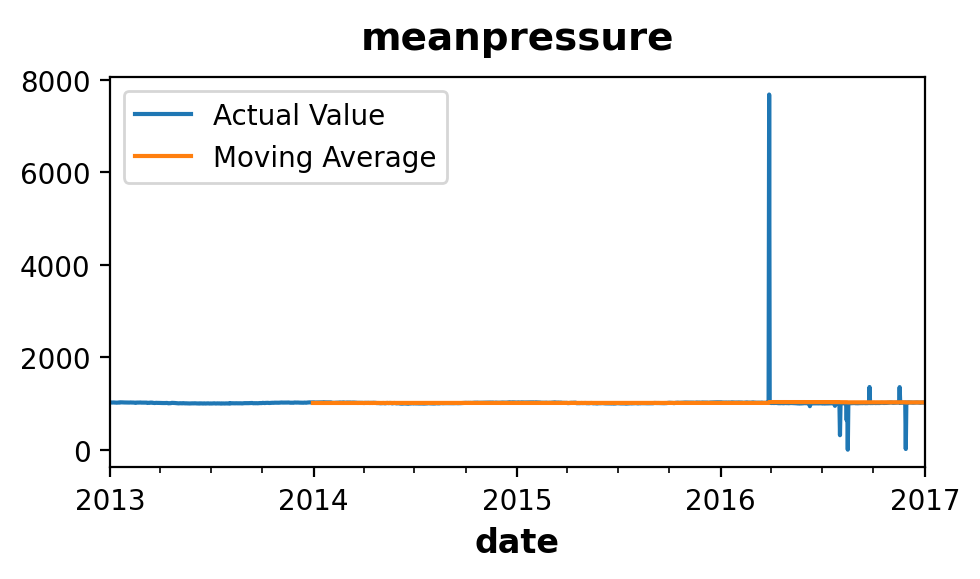

In [38]:
for column in df:
    plt.figure(figsize=(5, 3))  # Creates a new figure
    df[column].plot(kind='line')  # Plots the actual values
    df[column].rolling(window=365).mean().plot(kind='line')  # Plots the moving average
    plt.title(column)  # Sets the title of the plot as the column name
    plt.legend(['Actual Value', 'Moving Average'])  # Adds a legend
    plt.show() 

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


In [6]:
y = df.copy()

In [7]:
df.shape

(1462, 4)

In [11]:
## plt.style.use("seaborn-whitegrid")
#plt.rc(
#    "figure",
#    autolayout=True,
#    figsize=(11, 4),
#    titlesize=18,
#    titleweight='bold',
#)
#plt.rc(
#    "axes",
#    labelweight="bold",
#    labelsize="large",
#    titleweight="bold",
#    titlesize=16,
#    titlepad=10,
#)
#plot_params = dict(
#    color="0.75",
#    style=".-",
#    markeredgecolor="0.25",
#    markerfacecolor="0.25",
#)

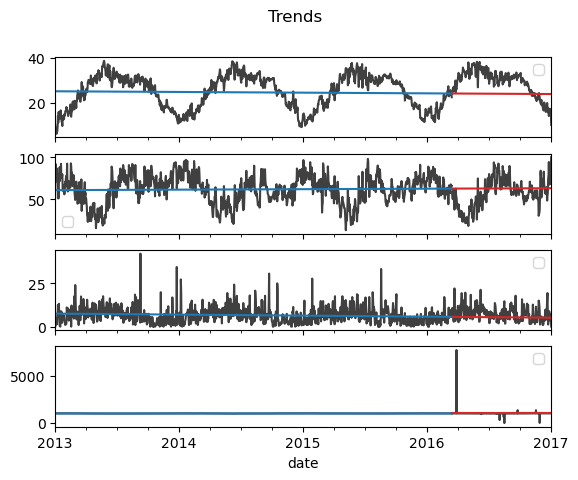

In [8]:
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=1,        # linear trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

idx_train, idx_test = train_test_split(
    y.index, test_size=0.2, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [9]:
#def seasonal_plot(X, y, period, freq, ax=None):
#    if ax is None:
#        _, ax = plt.subplots()
#    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
#    ax = sns.lineplot(
#        x=freq,
#        y=y,
#        hue=period,
#        data=X,
#        ci=False,
#        ax=ax,
#        palette=palette,
#        legend=False,
#    )
#    ax.set_title(f"Seasonal Plot ({period}/{freq})")
#    for line, name in zip(ax.lines, X[period].unique()):
#        y_ = line.get_ydata()[-1]
#        ax.annotate(
#            name,
#            xy=(1, y_),
#            xytext=(6, 0),
#            color=line.get_color(),
#            xycoords=ax.get_yaxis_transform(),
#            textcoords="offset points",
#            size=14,
#            va="center",
#        )
#    return ax
#def plot_periodogram(ts, detrend='linear', ax=None):
#    from scipy.signal import periodogram
#    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
#    freqencies, spectrum = periodogram(
#        ts,
#        fs=fs,
#        detrend=detrend,
#        window="boxcar",
#        scaling='spectrum',
#    )
#    if ax is None:
#        _, ax = plt.subplots()
#    ax.step(freqencies, spectrum, color="purple")
#    ax.set_xscale("log")
#    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
#    ax.set_xticklabels(
#        [
#            "Annual (1)",
#            "Semiannual (2)",
#            "Quarterly (4)",
#            "Bimonthly (6)",
#            "Monthly (12)",
#            "Biweekly (26)",
#            "Weekly (52)",
#            "Semiweekly (104)",
#        ],
#        rotation=30,
#    )
#    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
#    ax.set_ylabel("Variance")
#    ax.set_title("Periodogram")
#    return ax

In [10]:
#for col in df.columns:
#    plot_periodogram(y[col])

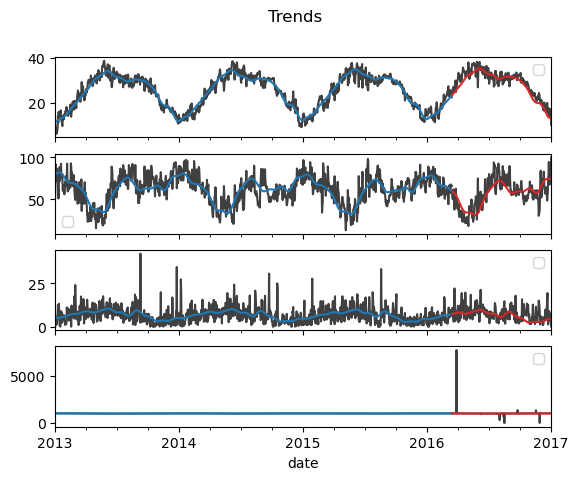

In [12]:
fourier = CalendarFourier(freq='Y', order=10)
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    additional_terms=[fourier],
    order=1,        # linear trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

idx_train, idx_test = train_test_split(
    y.index, test_size=0.2, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

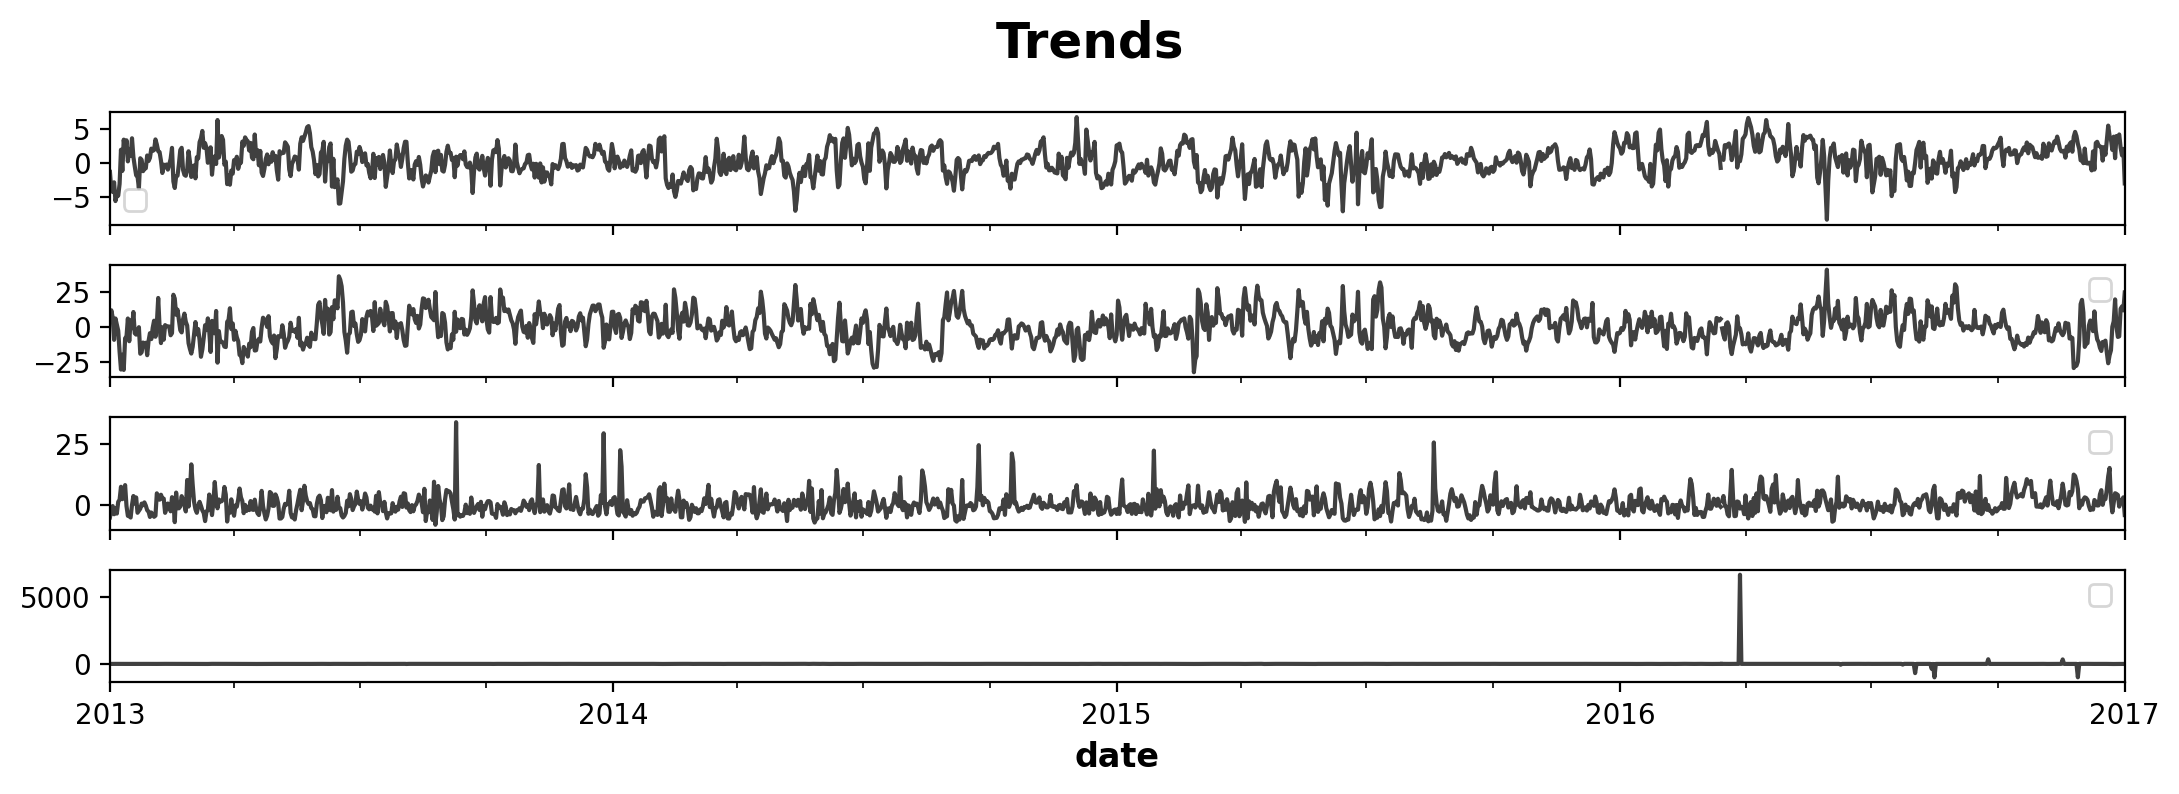

In [56]:

y_res_train = y_train - y_fit
y_res_test = y_test - y_pred
axs = y_res_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_res_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [13]:

#
#from scipy.signal import periodogram
#from statsmodels.graphics.tsaplots import plot_pacf
#
#
#def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
#    from matplotlib.offsetbox import AnchoredText
#    x_ = x.shift(lag)
#    if standardize:
#        x_ = (x_ - x_.mean()) / x_.std()
#    if y is not None:
#        y_ = (y - y.mean()) / y.std() if standardize else y
#    else:
#        y_ = x
#    corr = y_.corr(x_)
#    if ax is None:
#        fig, ax = plt.subplots()
#    scatter_kws = dict(
#        alpha=0.75,
#        s=3,
#    )
#    line_kws = dict(color='C3', )
#    ax = sns.regplot(x=x_,
#                     y=y_,
#                     scatter_kws=scatter_kws,
#                     line_kws=line_kws,
#                     lowess=True,
#                     ax=ax,
#                     **kwargs)
#    at = AnchoredText(
#        f"{corr:.2f}",
#        prop=dict(size="large"),
#        frameon=True,
#        loc="upper left",
#    )
#    at.patch.set_boxstyle("square, pad=0.0")
#    ax.add_artist(at)
#    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
#    return ax
#
#
#def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
#    import math
#    kwargs.setdefault('nrows', nrows)
#    kwargs.setdefault('ncols', math.ceil(lags / nrows))
#    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
#    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
#    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
#        if k + 1 <= lags:
#            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
#            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
#            ax.set(xlabel="", ylabel="")
#        else:
#            ax.axis('off')
#    plt.setp(axs[-1, :], xlabel=x.name)
#    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
#    fig.tight_layout(w_pad=0.1, h_pad=0.1)
#    return fig
#

In [ ]:
X_train

In [71]:
y_fit.index.names = ['date', 'factors']
y_pred.index.names = ['date', 'factors']

In [ ]:
y_train, y_fit

In [82]:
y_fit = y_fit.unstack()
y_pred = y_pred.unstack()

In [87]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train.meantemp, y_fit.meantemp, squared=False), mean_squared_error(y_test, y_pred, squared=False)

(2.0720965662140527, 104.89137902699312)

In [88]:
for col in y.columns:
    print(mean_squared_error(y_train[col], y_fit[col], squared=False), mean_squared_error(y_test[col], y_pred[col], squared=False))

2.0720965662140527 2.416018266395997
10.481356259698101 10.94885162771986
4.189316052925109 4.202886910542366
2.241474903128122 401.9977593033143


In [89]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y):
        # YOUR CODE HERE: fit self.model_1
        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(
            # YOUR CODE HERE: make predictions with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

        # YOUR CODE HERE: compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # YOUR CODE HERE: fit self.model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            # YOUR CODE HERE: predict with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # YOUR CODE HERE: add self.model_2 predictions to y_pred
        y_pred += self.model_2.predict(X_2)
        
        return y_pred.unstack()  # long to wide


In [91]:
fourier = CalendarFourier(freq='Y', order=10)
dp = DeterministicProcess(
    index=y.index, 
    constant=True, 
    additional_terms=[fourier],
    order=1, 
    drop=True)
X_1 = dp.in_sample()

In [93]:
X_2 = y.stack()

In [94]:
X_2

date                    
2013-01-01  meantemp          10.000000
            humidity          84.500000
            wind_speed         0.000000
            meanpressure    1015.666667
2013-01-02  meantemp           7.400000
                               ...     
2016-12-31  meanpressure    1016.100000
2017-01-01  meantemp          10.000000
            humidity         100.000000
            wind_speed         0.000000
            meanpressure    1016.000000
Length: 5848, dtype: float64

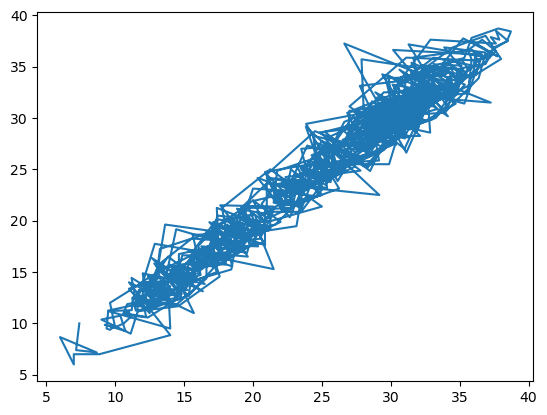

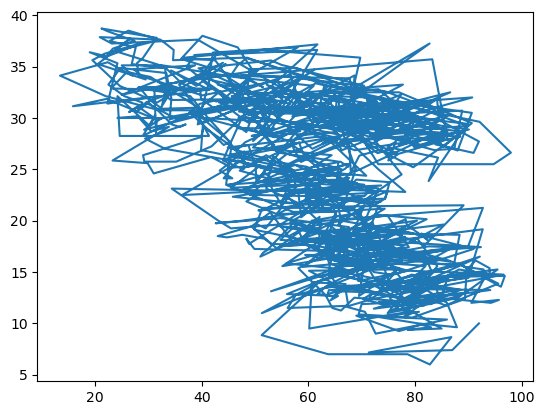

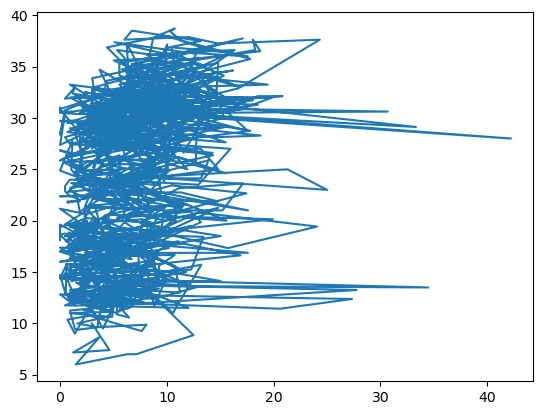

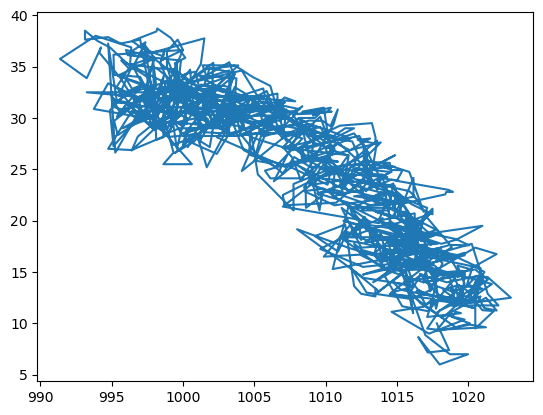

In [23]:
for col in y_train.columns:
    plt.plot(y_train[col], y_train['meantemp'].shift(1))
    plt.show()